In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
train_file_path = "/content/drive/My Drive/StockData/final_validtest_set.csv"
test_file_path = "/content/drive/My Drive/StockData/final_test_set.csv"

if os.path.exists(test_file_path):
    test_df = pd.read_csv(test_file_path)
    print("Data loaded from CSV.")
if os.path.exists(train_file_path)    :
    train_df = pd.read_csv(train_file_path)
    print("Data loaded from CSV.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded from CSV.
Data loaded from CSV.


In [ ]:
import pandas as pd
import numpy as np
import torch
from fastai.data.core import DataLoaders
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import TabularPandas, Normalize, RegressionBlock
from fastai.tabular.all import *
from fastai.torch_core import tensor
from torch import nn
from fastai.learner import Learner
from fastai.metrics import mse
from fastai.callback.schedule import *
import yfinance as yf
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
cont_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume', 'rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band'] # Remove 'Ticker' from cont_vars
seq_length = 20
forecast_horizon = 14
target_col = 'return_14d'
ticker_col = 'Ticker'
date_col = 'Date'
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        return self.fc(last_out).squeeze(-1)


from fastai.learner import load_learner
import os

learner_path = '/content/drive/MyDrive/StockModels'
export_path = os.path.join(learner_path, 'lstm_learner.pkl')


try:
    learner = load_learner(export_path)
    print(learner)
except FileNotFoundError:
    print(f"Error: Learner file not found at {export_path}. Ensure the training cell was run successfully.")

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

seq_length = 20
forecast_horizon = 14
cont_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band'] # Must match the features used for training
target_col = 'return_14d'
ticker_col = 'Ticker'
date_col = 'Date'
batch_size = 64

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, df, seq_length, forecast_horizon, cont_vars, target_col, ticker_col, date_col, index_map=None):
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.cont_vars = cont_vars
        self.target_col = target_col
        self.ticker_col = ticker_col
        self.date_col = date_col

        self.original_index = df.index

        df = df.sort_values([ticker_col, date_col]).reset_index(drop=True)

        self.df = df

        self.groups = list(df.groupby(ticker_col))

        if index_map is None:
            self.index_map = []
            for t_idx, (ticker, group) in enumerate(self.groups):
                n = len(group)
                max_start = n - seq_length - forecast_horizon
                if max_start >= 0:
                     for start in range(max_start + 1):
                         target_pos_in_group = start + seq_length + forecast_horizon - 1
                         if start + seq_length <= n and target_pos_in_group < n:
                              original_idx = group.iloc[target_pos_in_group].name
                              self.index_map.append((t_idx, start, original_idx))
        else:
            self.index_map = index_map


    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        t_idx, start, original_idx = self.index_map[idx]
        ticker, group = self.groups[t_idx]

        seq_start = start
        seq_end = start + self.seq_length
        target_pos_in_group = seq_end + self.forecast_horizon - 1

        features = group.iloc[seq_start:seq_end][self.cont_vars].values.astype(np.float32)


        target = group.iloc[target_pos_in_group][self.target_col].astype(np.float32)

        X = torch.tensor(features)
        y = torch.tensor(target)

        return X, y, original_idx



if 'test_df' in locals():
     test_df_for_dataset = test_df.copy()

     test_df_for_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)


     if not test_df_for_dataset.empty:
         cont_vars_test = [col for col in cont_vars if col in test_df_for_dataset.columns]
         if cont_vars_test:
             test_df_for_dataset[cont_vars_test] = test_df_for_dataset.groupby('Ticker')[cont_vars_test].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))


             for col in cont_vars_test:
                 median_val = test_df_for_dataset[col].median()
                 if pd.isna(median_val):
                     test_df_for_dataset[col].fillna(0, inplace=True)
                 else:
                     test_df_for_dataset[col].fillna(median_val, inplace=True)
         else:
             print("Warning: None of the specified continuous variables found in the test DataFrame.")



     if target_col in test_df_for_dataset.columns:
          initial_test_rows = len(test_df_for_dataset)
          test_df_for_dataset = test_df_for_dataset.dropna(subset=[target_col]).reset_index(drop=True)
          test_df_for_dataset = test_df_for_dataset[~test_df_for_dataset[target_col].isin([np.inf, -np.inf])].reset_index(drop=True)
          if len(test_df_for_dataset) < initial_test_rows:
              print(f"Dropped {initial_test_rows - len(test_df_for_dataset)} rows from test_df_for_dataset due to NaN/inf in target column.")
     else:
         print(f"Warning: Target column '{target_col}' not found in test_df_for_dataset. Skipping target cleaning.")

     test_df_for_dataset = test_df_for_dataset.sort_values(['Ticker', 'Date']).reset_index(drop=True)

     test_ds = TimeSeriesDataset(
         test_df_for_dataset, seq_length, forecast_horizon, cont_vars, target_col,
         ticker_col, date_col
     )
     test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)
     preds_list = []
     targs_list = []
     original_indices_list = []

     learner.model.eval()

     eval_device = learner.dls.device if hasattr(learner.dls, 'device') and learner.dls.device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     learner.model.to(eval_device)

     with torch.no_grad():
         for inputs, targets, indices in test_dl:

             inputs = inputs.to(eval_device)

             outputs = learner.model(inputs)

             preds_list.append(outputs.cpu().numpy())
             targs_list.append(targets.cpu().numpy())
             original_indices_list.append(indices.cpu().numpy())


     preds = np.concatenate(preds_list)
     targs = np.concatenate(targs_list)
     original_indices = np.concatenate(original_indices_list)

     print(f"Generated {len(preds)} predictions from the test set.")
     print(f"Collected {len(targs)} corresponding true values.")
     print(f"Collected {len(original_indices)} corresponding original indices.")


     finite_mask_metrics = np.isfinite(preds) & np.isfinite(targs)
     if np.sum(finite_mask_metrics) > 0:
         mae_val = mean_absolute_error(targs[finite_mask_metrics], preds[finite_mask_metrics])
         mse_val = mean_squared_error(targs[finite_mask_metrics], preds[finite_mask_metrics])
         print(f"\nTest MAE (on finite prediction/target pairs): {mae_val:.4f}")
         print(f"Test MSE (on finite prediction/target pairs): {mse_val:.4f}")
     else:
          print("\nNo finite prediction/target pairs available to compute MAE/MSE.")
          mae_val, mse_val = np.nan, np.nan


else:
    print("Error: test_df not found. Ensure previous cells creating and cleaning test data were run.")

<ipython-input-34-105bca5c1714>:113: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df_for_dataset[cont_vars_test] = test_df_for_dataset.groupby('Ticker')[cont_vars_test].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))
<ipython-input-34-105bca5c1714>:113: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df_for_dataset[cont_vars_test] = test_df_for_dataset.groupby('Ticker')[cont_vars_test].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))
<ipython-input-34-105bca5c1714>:122: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

Dropped 6936 rows from test_df_for_dataset due to NaN/inf in target column.
Generated 44563 predictions from the test set.
Collected 44563 corresponding true values.
Collected 44563 corresponding original indices.

Test MAE (on finite prediction/target pairs): 0.0538
Test MSE (on finite prediction/target pairs): 0.0056



--- Evaluation Metrics ---
Test MAE (on finite data): 0.0538
Test MSE (on finite data): 0.0056


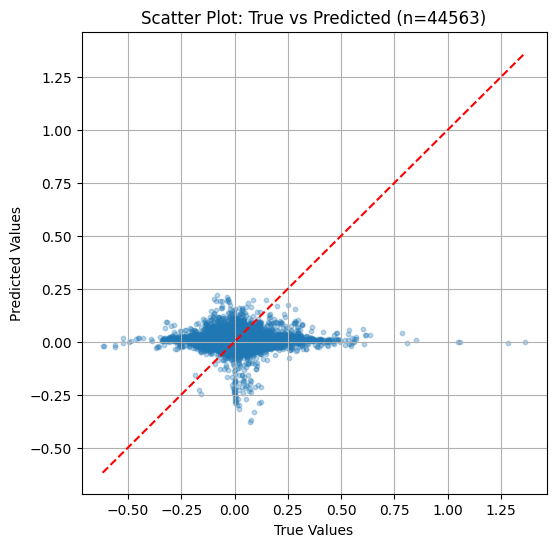

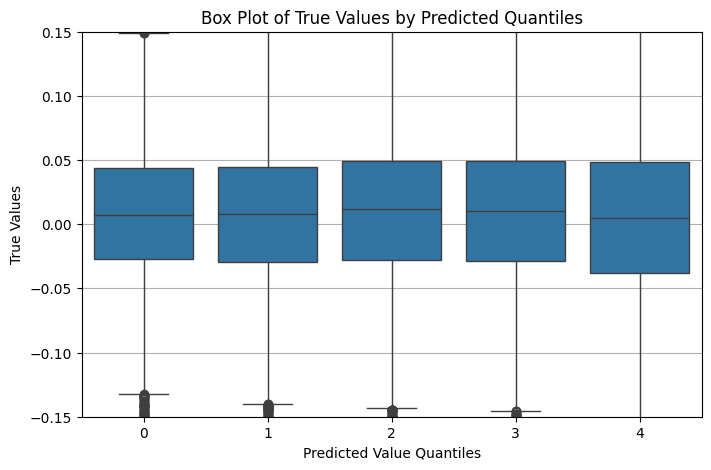

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

clip_min, clip_max = -0.5, 1.0  # Re-define for clarity

# --- Filter test_df_cleaned using the collected indices ---
if len(original_indices) > 0:
    original_indices = original_indices.astype(int)

    # Use the original test_df (before any subsetting/cleaning in the prediction cell)
    # as the source, as its index corresponds to the original_indices.
    # Ensure this test_df contains all necessary columns ('Date', 'Ticker', 'rsi', 'stochastic', 'return_14d').
    if 'test_df' in locals():
        # Check if all original_indices are in the index of test_df
        if not pd.Index(original_indices).isin(test_df.index).all():
            print("Warning: Some original indices are not present in the original test_df.")
            valid_indices_mask = pd.Index(original_indices).isin(test_df.index)
            original_indices = original_indices[valid_indices_mask]
            # Filter preds and targs accordingly
            preds = preds[valid_indices_mask]
            targs = targs[valid_indices_mask]
            print(f"Filtered down to {len(original_indices)} valid indices.")

        # Select the relevant rows from the original test_df using the filtered indices
        eval_df_source = test_df.loc[original_indices].reset_index(drop=True)

        if len(targs) == len(preds) == len(eval_df_source):
            # Create eval_df with columns for plotting and analysis
            eval_df = pd.DataFrame({
                'Date': eval_df_source['Date'].values,
                'Ticker': eval_df_source['Ticker'].values,
                'Close': eval_df_source['Close'].values,
                'y_true': targs, # Use the collected targets
                'y_pred': preds, # Use the collected predictions
                'rsi': eval_df_source['rsi'].values, # Use RSI from the source data
                'stochastic': eval_df_source['stochastic'].values, # Use Stochastic from the source data
                'return_14d': eval_df_source['return_14d'].values # Use the actual return_14d from the source data
            })

            print("\n--- Evaluation Metrics ---")
            finite_mask_metrics = np.isfinite(preds) & np.isfinite(targs)
            if np.sum(finite_mask_metrics) > 0:
                # Calculate metrics using the collected preds and targs
                mae_val = mean_absolute_error(targs[finite_mask_metrics], preds[finite_mask_metrics])
                mse_val = mean_squared_error(targs[finite_mask_metrics], preds[finite_mask_metrics])
                print(f"Test MAE (on finite data): {mae_val:.4f}")
                print(f"Test MSE (on finite data): {mse_val:.4f}")
            else:
                print("No finite prediction-target pairs to compute MAE/MSE.")


            # --- Scatter plot of True vs Predicted ---
            # Use the collected preds and targs directly, filtered by finite_mask_metrics
            plot_preds_scatter = preds[finite_mask_metrics]
            plot_targs_scatter = targs[finite_mask_metrics]

            plt.figure(figsize=(6,6))
            plt.scatter(plot_targs_scatter, plot_preds_scatter, alpha=0.3, s=10)
            min_val = min(plot_targs_scatter.min(), plot_preds_scatter.min())
            max_val = max(plot_targs_scatter.max(), plot_preds_scatter.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--')
            plt.xlabel("True Values")
            plt.ylabel("Predicted Values")
            plt.title(f"Scatter Plot: True vs Predicted (n={len(plot_preds_scatter)})")
            plt.grid(True)
            plt.show()

            # --- Box plot of True Values by Predicted Quantiles ---
            # Use eval_df which contains 'y_pred' and 'y_true'
            valid_preds_for_quantile = eval_df['y_pred'][np.isfinite(eval_df['y_pred'])]

            if len(np.unique(valid_preds_for_quantile)) >= 5:
                try:
                    # Calculate quantiles based on finite predictions
                    quantiles = pd.qcut(valid_preds_for_quantile, q=5, labels=False, duplicates='drop')
                    # Align quantiles back to the original eval_df index
                    quantile_aligned = pd.Series(quantiles, index=valid_preds_for_quantile.index)
                    # Create boxplot_df using eval_df and the aligned quantiles
                    boxplot_df = eval_df.loc[quantile_aligned.index, ['y_true']].copy()
                    boxplot_df['PredictedQuantile'] = quantile_aligned
                    boxplot_df = boxplot_df.dropna() # Drop any rows with NaN true values or quantiles

                    plt.figure(figsize=(8,5))
                    sns.boxplot(x='PredictedQuantile', y='y_true', data=boxplot_df)
                    plt.xlabel("Predicted Value Quantiles")
                    plt.ylabel("True Values")
                    plt.title("Box Plot of True Values by Predicted Quantiles")
                    plt.grid(True)
                    plt.ylim(-0.15,0.15)
                    plt.show()

                except Exception as e:
                    print(f"Error generating Box Plot: {e}")
            else:
                print(f"Could not generate Box Plot: Only {len(np.unique(valid_preds_for_quantile))} unique predicted values found or not enough finite predictions.")

        else:
            print(f"Length mismatch: targs ({len(targs)}), preds ({len(preds)}), eval_df_source ({len(eval_df_source)})")
    else:
        print("Error: test_df not found. Ensure previous cells creating and cleaning test data were run.")

else:
    print("No original indices collected. Skipping evaluation.")



--- Running Model Strategy Backtest ---
--- End of Backtest: Processing 0 remaining open positions ---
Total Capital Returned from Final Closeout: 0.00
Total Profit/Loss from Final Closeout: 0.00
Final Portfolio Value after Closeout: -81977.90

--- Running Baseline Strategy Calculation ---
Baseline Strategy calculated for 137 dates.



[*********************100%***********************]  1 of 1 completed



--- Plotting Data Check (Filtered) ---
Filtered Strategy Returns Head:
Date
2024-06-17    0.0
2024-06-18    0.0
2024-06-20    0.0
2024-06-21    0.0
2024-06-24    0.0
dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 116 entries, 2024-06-17 to 2024-11-29
Series name: None
Non-Null Count  Dtype  
--------------  -----  
116 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB
Filtered Strategy Returns Info:
None
Number of finite Filtered Strategy Returns: 116 out of 116
Filtered Portfolio History Head:
Date
2024-06-17    10000.0
2024-06-18    10000.0
2024-06-20    10000.0
2024-06-21    10000.0
2024-06-24    10000.0
dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 116 entries, 2024-06-17 to 2024-11-29
Series name: None
Non-Null Count  Dtype  
--------------  -----  
116 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB
Filtered Portfolio History Info:
None
Number of finite Filtered Portfolio History: 116 out of 116
Filtered Baseline Retur

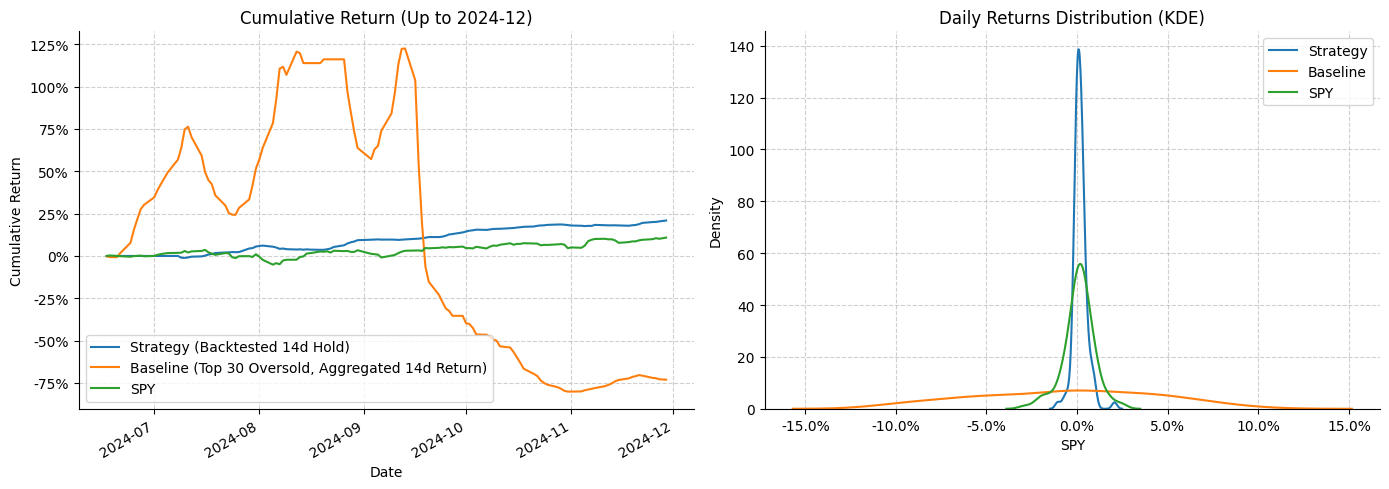

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import yfinance as yf
import ta


if len(original_indices) > 0:
    original_indices = original_indices.astype(int)

    if 'test_df' in locals():
        if not pd.Index(original_indices).isin(test_df.index).all():
            print("Warning: Some original indices are not present in the original test_df.")
            valid_indices_mask = pd.Index(original_indices).isin(test_df.index)
            original_indices = original_indices[valid_indices_mask]
            preds = preds[valid_indices_mask]
            targs = targs[valid_indices_mask]
            print(f"Filtered down to {len(original_indices)} valid indices.")

        eval_df_source = test_df.loc[original_indices].reset_index(drop=True)

        if len(targs) == len(preds) == len(eval_df_source):
            eval_df = pd.DataFrame({
                'Date': eval_df_source['Date'].values,
                'Ticker': eval_df_source['Ticker'].values,
                'Close': eval_df_source['Close'].values,
                'y_true': targs,
                'y_pred': preds,
                'rsi': eval_df_source['rsi'].values,
                'stochastic': eval_df_source['stochastic'].values,
                'return_14d': eval_df_source['return_14d'].values
            })
        eval_df['AbsError'] = np.abs(eval_df['y_true'] - eval_df['y_pred'])

if 'eval_df' not in locals() or 'Close' not in eval_df.columns or 'rsi' not in eval_df.columns or 'stochastic' not in eval_df.columns:
    print("Error: eval_df not found or missing required columns ('Close', 'rsi', 'stochastic'). Cannot perform backtest and baseline.")
else:
    eval_df['Date'] = pd.to_datetime(eval_df['Date'])
    eval_df = eval_df.sort_values(['Date', 'Ticker']).reset_index(drop=True)

    predictions_wide = eval_df.pivot(index='Date', columns='Ticker', values='y_pred')
    eval_df_wide = eval_df.pivot(index='Date', columns='Ticker', values='return_14d')
    close_prices_wide = eval_df.pivot(index='Date', columns='Ticker', values='Close')

    common_dates = predictions_wide.index.intersection(eval_df_wide.index).intersection(close_prices_wide.index)
    predictions_wide = predictions_wide.loc[common_dates].sort_index()
    eval_df_wide = eval_df_wide.loc[common_dates].sort_index()
    close_prices_wide = close_prices_wide.loc[common_dates].sort_index()

    assert eval_df_wide.index.equals(predictions_wide.index)
    assert eval_df_wide.index.equals(close_prices_wide.index)
    assert eval_df_wide.shape == predictions_wide.shape
    assert eval_df_wide.shape == close_prices_wide.shape


    N_LONG = 50
    N_SHORT = 50
    HOLDING_PERIOD = 14
    INITIAL_CAPITAL = 10000

    EQUITY_PER_POSITION = INITIAL_CAPITAL / (N_LONG + N_SHORT) if (N_LONG + N_SHORT) > 0 else 100



    print("\n--- Running Model Strategy Backtest ---")
    cash = INITIAL_CAPITAL
    portfolio_value = INITIAL_CAPITAL
    portfolio_history = pd.Series(index=eval_df_wide.index, dtype=float)
    if not eval_df_wide.index.empty:
        portfolio_history.iloc[0] = INITIAL_CAPITAL
    open_positions = {}
    daily_returns_proper = pd.Series(index=eval_df_wide.index, dtype=float)



    for current_idx in range(len(eval_df_wide.index)):
        current_date = eval_df_wide.index[current_idx]

        previous_portfolio_value = portfolio_value if current_idx > 0 else INITIAL_CAPITAL


        exited_tickers_today = []
        profit_loss_from_exits = 0
        capital_returned_from_exits = 0

        tickers_to_remove = []
        for ticker, pos_info in list(open_positions.items()):
             if current_idx >= pos_info['entry_idx'] + HOLDING_PERIOD:
                 exited_tickers_today.append(ticker)
                 profit_loss = pos_info['entry_value'] * pos_info['return_on_exit']
                 profit_loss_from_exits += profit_loss
                 capital_returned_from_exits += pos_info['entry_value']
                 tickers_to_remove.append(ticker)

        for ticker in tickers_to_remove:
             del open_positions[ticker]

        cash += capital_returned_from_exits + profit_loss_from_exits



        signaled_tickers_today = []
        if current_idx < len(predictions_wide):
            predictions_today = predictions_wide.iloc[current_idx]
            actual_returns_today_entry = eval_df_wide.iloc[current_idx]
            close_prices_today = close_prices_wide.iloc[current_idx]

            long_candidates = predictions_today.where(predictions_today > 0).dropna().rank(ascending=False)
            short_candidates = predictions_today.where(predictions_today < 0).dropna().rank(ascending=True)

            long_signals_today = long_candidates[long_candidates <= N_LONG].index.tolist()
            short_signals_today = short_candidates[short_candidates <= N_SHORT].index.tolist()

            signaled_tickers_today = list(set(long_signals_today + short_signals_today))
            signaled_tickers_today = [t for t in signaled_tickers_today if t not in open_positions]

            num_new_positions = len(signaled_tickers_today)
            capital_for_new_positions = num_new_positions * EQUITY_PER_POSITION


            cash -= capital_for_new_positions

            for ticker in signaled_tickers_today:
                return_on_exit = actual_returns_today_entry.get(ticker)
                entry_price = close_prices_today.get(ticker)

                if pd.notna(return_on_exit) and pd.notna(entry_price) and entry_price != 0:
                     open_positions[ticker] = {
                        'entry_idx': current_idx,
                        'entry_date': current_date,
                        'entry_value': EQUITY_PER_POSITION,
                        'return_on_exit': return_on_exit,
                        'entry_price': entry_price
                     }


        value_of_open_positions = sum(pos_info['entry_value'] for pos_info in open_positions.values())
        portfolio_value = cash + value_of_open_positions


        daily_return = (portfolio_value - previous_portfolio_value) / previous_portfolio_value if previous_portfolio_value != 0 else 0

        daily_returns_proper.loc[current_date] = daily_return
        portfolio_history.loc[current_date] = portfolio_value


    print(f"--- End of Backtest: Processing {len(open_positions)} remaining open positions ---")
    profit_loss_from_final_closeout = 0
    capital_returned_from_final_closeout = 0

    if not eval_df_wide.index.empty:
        last_idx = len(eval_df_wide.index) - 1
        last_date = eval_df_wide.index[last_idx]
        close_prices_last_day = close_prices_wide.iloc[last_idx]

        tickers_to_remove = []
        for ticker, pos_info in list(open_positions.items()):
             entry_price = pos_info['entry_price']
             last_price = close_prices_last_day.get(ticker)

             if pd.notna(entry_price) and entry_price != 0 and pd.notna(last_price):
                 actual_partial_return = (last_price / entry_price) - 1
                 profit_loss = pos_info['entry_value'] * actual_partial_return
                 profit_loss_from_final_closeout += profit_loss
                 capital_returned_from_final_closeout += pos_info['entry_value']

                 tickers_to_remove.append(ticker)


        cash += capital_returned_from_final_closeout + profit_loss_from_final_closeout
        final_portfolio_value = cash

        if not portfolio_history.empty:
           portfolio_history.iloc[-1] = final_portfolio_value

        if len(eval_df_wide.index) > 1:
             previous_to_last_portfolio_value = portfolio_history.iloc[-2]
             daily_return_last_day = (final_portfolio_value - previous_to_last_portfolio_value) / previous_to_last_portfolio_value if previous_to_last_portfolio_value != 0 else 0
             daily_returns_proper.iloc[-1] = daily_return_last_day
        elif len(eval_df_wide.index) == 1:
             daily_return_last_day = (final_portfolio_value - INITIAL_CAPITAL) / INITIAL_CAPITAL if INITIAL_CAPITAL != 0 else 0
             daily_returns_proper.iloc[-1] = daily_return_last_day

    print(f"Total Capital Returned from Final Closeout: {capital_returned_from_final_closeout:.2f}")
    print(f"Total Profit/Loss from Final Closeout: {profit_loss_from_final_closeout:.2f}")
    print(f"Final Portfolio Value after Closeout: {final_portfolio_value:.2f}")



    daily_returns_proper = daily_returns_proper.dropna().sort_index()
    portfolio_history = portfolio_history.dropna().sort_index()


    print("\n--- Running Baseline Strategy Calculation ---")
    df_baseline = eval_df.copy()

    if 'rsi' in df_baseline.columns and 'stochastic' in df_baseline.columns:
         df_baseline['oversold_score'] = (df_baseline['rsi'] + df_baseline['stochastic']) / 2.0


         baseline_buy_condition = (df_baseline['rsi'] < 30) & (df_baseline['stochastic'] < 20)


         df_baseline.loc[baseline_buy_condition, 'baseline_oversold_rank'] = df_baseline[baseline_buy_condition] \
             .groupby('Date')['oversold_score'] \
             .rank(method='first', ascending=True)


         N_BASELINE = 30
         df_baseline['baseline_signal'] = np.where(
             df_baseline['baseline_oversold_rank'] <= N_BASELINE, 1, 0
         )

.
         df_baseline['signaled_baseline_return'] = df_baseline['return_14d'] * df_baseline['baseline_signal']


         baseline_daily_returns = df_baseline.groupby('Date')['signaled_baseline_return'].sum() / \
                                  np.maximum(1, df_baseline.groupby('Date')['baseline_signal'].sum())

         baseline_daily_returns = baseline_daily_returns.where(df_baseline.groupby('Date')['baseline_signal'].sum() > 0, 0)

         baseline_daily_returns = baseline_daily_returns.reindex(daily_returns_proper.index).fillna(0)

         print(f"Baseline Strategy calculated for {len(baseline_daily_returns)} dates.")

    else:
        print("Warning: 'rsi' or 'stochastic' columns not found in eval_df. Skipping baseline calculation.")
        baseline_daily_returns = pd.Series(dtype=float)

    cut_off_date = pd.to_datetime('2024-12-01')
    portfolio_history_filtered = portfolio_history[portfolio_history.index < cut_off_date]
    daily_returns_proper_filtered = daily_returns_proper[daily_returns_proper.index < cut_off_date]

    baseline_daily_returns_filtered = baseline_daily_returns[baseline_daily_returns.index < cut_off_date]

    try:
        start_date = portfolio_history_filtered.index.min()
        end_date = portfolio_history_filtered.index.max()

        if hasattr(start_date, 'tzinfo') and start_date.tzinfo is not None:
            start_date = start_date.tz_convert(None)
        if hasattr(end_date, 'tzinfo') and end_date.tzinfo is not None:
             end_date = end_date.tz_convert(None)

        spy_ticker = 'SPY'

        print(f"\nDownloading benchmark data for plotting up to {end_date.strftime('%Y-%m-%d')}")
        spy_data = yf.download(spy_ticker, start=start_date, end=end_date + pd.Timedelta(days=1), interval="1d", auto_adjust=True, progress=True)

        if spy_data.empty:
            print(f"Warning: Could not download benchmark data for {spy_ticker} up to {end_date}. Using zero return benchmark.")
            benchmark_returns_to_plot_filtered = pd.Series(0, index=portfolio_history_filtered.index)
            benchmark_label = 'No Benchmark Data'
        else:
            if hasattr(spy_data.index, 'tzinfo') and spy_data.index.tzinfo is not None:
                 spy_data.index = spy_data.index.tz_convert(None)

            benchmark_returns_spy = spy_data['Close'].pct_change().fillna(0)
            benchmark_returns_to_plot_filtered = benchmark_returns_spy.reindex(portfolio_history_filtered.index).ffill().bfill().fillna(0)

            benchmark_label = f'{spy_ticker}'

    except Exception as e:
        print(f"An error occurred while downloading or processing benchmark data for plotting: {e}")
        benchmark_returns_to_plot_filtered = pd.Series(0, index=portfolio_history_filtered.index)
        benchmark_label = 'Benchmark Error'



    fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

    if not portfolio_history_filtered.empty:
        initial_filtered_value = portfolio_history_filtered.iloc[0]
        cumulative_percentage_return_filtered = (portfolio_history_filtered / initial_filtered_value) - 1.0
        cumulative_percentage_return_filtered.plot(ax=axes[0], label=f'Strategy (Backtested {HOLDING_PERIOD}d Hold)', lw=1.5)
    else:
        print("Filtered portfolio history is empty. Cannot plot strategy cumulative return.")

    if not baseline_daily_returns_filtered.empty:
         baseline_cumulative_filtered = baseline_daily_returns_filtered.add(1).cumprod().sub(1)
         baseline_cumulative_filtered.plot(ax=axes[0], label=f'Baseline (Top {N_BASELINE} Oversold, Aggregated 14d Return)', lw=1.5) # Add baseline plot
    else:
         print("Filtered baseline daily returns is empty. Cannot plot baseline cumulative return.")


    benchmark_cumulative_filtered = benchmark_returns_to_plot_filtered.add(1).cumprod().sub(1)
    benchmark_cumulative_filtered.plot(ax=axes[0], label=benchmark_label, lw=1.5)

    axes[0].set_title('Cumulative Return (Up to 2024-12)')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Cumulative Return')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    clip_min_kde, clip_max_kde = -0.1, 0.1
    strategy_returns_finite_filtered = daily_returns_proper_filtered[np.isfinite(daily_returns_proper_filtered)]
    baseline_returns_finite_filtered = baseline_daily_returns_filtered[np.isfinite(baseline_daily_returns_filtered)] # Get finite baseline returns
    benchmark_returns_finite_filtered = benchmark_returns_to_plot_filtered[np.isfinite(benchmark_returns_to_plot_filtered)]

    if not strategy_returns_finite_filtered.empty:
        sns.kdeplot(strategy_returns_finite_filtered.clip(clip_min_kde, clip_max_kde), ax=axes[1], label='Strategy', lw=1.5)
    else:
        print("Warning: Filtered daily strategy returns are all non-finite or empty. Cannot plot strategy KDE.")

    if not baseline_returns_finite_filtered.empty:
         sns.kdeplot(baseline_returns_finite_filtered.clip(clip_min_kde, clip_max_kde), ax=axes[1], label='Baseline', lw=1.5)
    else:
         print("Warning: Filtered baseline daily returns are all non-finite or empty. Cannot plot baseline KDE.")


    if not benchmark_returns_finite_filtered.empty:
        if isinstance(benchmark_returns_finite_filtered, pd.DataFrame):
            benchmark_returns_finite_filtered = benchmark_returns_finite_filtered.iloc[:, 0]
        sns.kdeplot(benchmark_returns_finite_filtered.clip(clip_min_kde, clip_max_kde), ax=axes[1], label=benchmark_label, lw=1.5)
    else:
         print("Warning: Benchmark returns are all non-finite or empty. Cannot plot benchmark KDE.")

    axes[1].set_title('Daily Returns Distribution (KDE)')
    axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    sns.despine()
    fig.tight_layout()
    plt.show()